# Classifiying Cannabis Strains

We're going to classify images of cannabis strains into 2 classes:
- indica
- sativa (higher CBD, lower THC)

The human eye can differentiate between both usually by simply looking at their leaves

![img](https://www.leafscience.com/wp-content/uploads/2017/04/indica-vs-sativa-leaves.jpg)

We could also have tried to use images of buds or images of plants in flowering stages, this would require more data as well as higher resolution data (and deep expertise to label the data)

## Import libraries

In [23]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [24]:
from fastbook import *
from fastai.vision.widgets import *

In [73]:
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 

## Loading the data

In [25]:
path = Path('cannabis')

In [26]:
cannabis = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

Let's look at some example of images in the training and validation sets

In [27]:
dls = cannabis.dataloaders(path)

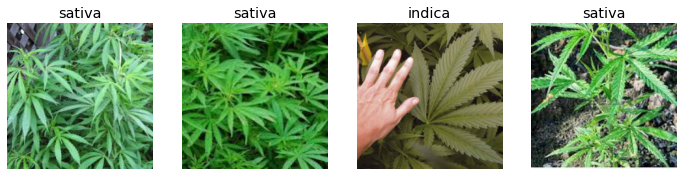

In [28]:
dls.train.show_batch(max_n=4, nrows=1)

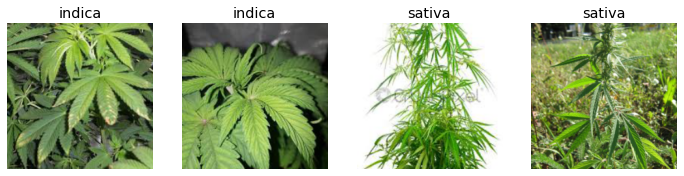

In [29]:
dls.valid.show_batch(max_n=4, nrows=1)

## Training the model

In [30]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.469445,1.505163,0.650000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.233551,1.130874,0.600000,00:03
1,1.180740,0.770631,0.350000,00:03
2,0.947916,0.528751,0.200000,00:03
3,0.757501,0.475377,0.200000,00:03
4,0.628932,0.497044,0.200000,00:03
5,0.544720,0.531355,0.200000,00:03
6,0.485747,0.557144,0.200000,00:03
7,0.428714,0.580005,0.200000,00:03


## First Evaluation

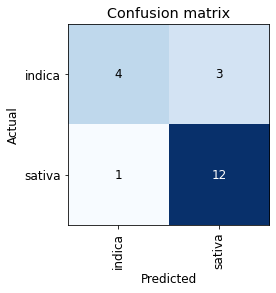

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Looking at examples wrongly classified

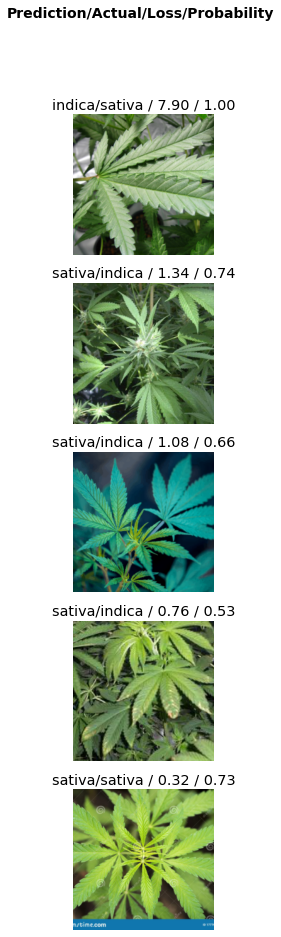

In [32]:
interp.plot_top_losses(5, nrows=5)

## Removing/Updating some examples 

In [33]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [36]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [37]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Updating the data and training the model again

In [38]:
cannabis = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

In [39]:
dls = cannabis.dataloaders(path)

In [40]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.695998,1.279161,0.631579,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.802003,0.980613,0.578947,00:03
1,1.662746,0.743650,0.473684,00:03
2,1.321862,0.629835,0.263158,00:03
3,1.053659,0.578364,0.157895,00:03
4,0.859470,0.579072,0.157895,00:03
5,0.718189,0.612072,0.157895,00:03
6,0.614533,0.646851,0.105263,00:03
7,0.536080,0.650863,0.105263,00:03


## Second Evaluation

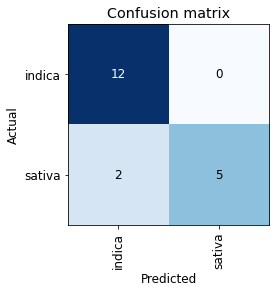

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Exporting the model

In [47]:
# export the model
learn.export()

In [48]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [49]:
learn_inf = load_learner(path/'export.pkl')

In [51]:
learn.dls.vocab

['indica', 'sativa']

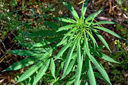

In [63]:
im = Image.open(dls.train.items[0])
im.to_thumb(128,128)

In [71]:
np.asarray(im).shape

(183, 275, 3)

In [70]:
np.asarray(im)

array([[[115, 126,  70],
        [ 96, 107,  51],
        [ 85,  94,  41],
        ...,
        [ 59,  69,   6],
        [ 70,  80,  17],
        [ 86,  97,  29]],

       [[ 64,  77,  21],
        [ 68,  78,  25],
        [ 79,  89,  36],
        ...,
        [ 78,  85,  43],
        [ 81,  88,  46],
        [ 85,  93,  46]],

       [[ 59,  72,  18],
        [ 65,  78,  24],
        [ 95, 105,  52],
        ...,
        [111, 113,  92],
        [104, 106,  84],
        [ 95,  97,  73]],

       ...,

       [[104,  86,  62],
        [ 61,  39,  15],
        [ 63,  33,   9],
        ...,
        [ 60,  50,  25],
        [ 66,  56,  31],
        [ 75,  65,  40]],

       [[ 87,  71,  45],
        [ 57,  36,   9],
        [ 67,  40,  13],
        ...,
        [ 54,  44,  19],
        [ 63,  53,  28],
        [ 76,  66,  41]],

       [[149, 135, 108],
        [119,  99,  72],
        [ 68,  42,  15],
        ...,
        [ 56,  46,  21],
        [ 66,  56,  31],
        [ 77,  67,  42]]

In [64]:
learn_inf.predict(PILImage.create(dls.train.items[0]))

('sativa', TensorImage(1), TensorImage([0.0088, 0.9912]))

## Building a widget

In [65]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))

In [66]:
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

In [67]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [68]:
VBox([widgets.Label('Select your strain!'), 
      btn_upload, btn_run, out_pl, lbl_pred])